In [3]:
!wget https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-01.parquet -O jan.parquet
!wget https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-02.parquet -O feb.parquet

--2022-05-22 16:12:30--  https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-01.parquet
Resolving nyc-tlc.s3.amazonaws.com (nyc-tlc.s3.amazonaws.com)... 52.217.235.81
Connecting to nyc-tlc.s3.amazonaws.com (nyc-tlc.s3.amazonaws.com)|52.217.235.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11886281 (11M) [binary/octet-stream]
Saving to: ‘jan.parquet’

jan.parquet         100%[===================>]  11.33M  13.4MB/s    in 0.8s    

2022-05-22 16:12:31 (13.4 MB/s) - ‘jan.parquet’ saved [11886281/11886281]

--2022-05-22 16:12:31--  https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-02.parquet
Resolving nyc-tlc.s3.amazonaws.com (nyc-tlc.s3.amazonaws.com)... 52.217.235.81
Connecting to nyc-tlc.s3.amazonaws.com (nyc-tlc.s3.amazonaws.com)|52.217.235.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10645466 (10M) [binary/octet-stream]
Saving to: ‘feb.parquet’

feb.parquet         100%[===================>]  10.15M  12

In [4]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [5]:
jan_df = pd.read_parquet("jan.parquet")
feb_df = pd.read_parquet("feb.parquet")

In [8]:
jan_df.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037


### Q1.Read the data for January. How many records are there?

In [7]:
print('A1:', len(jan_df))

A1: 1154112


### Q2. What's the average trip duration in January?

In [9]:
jan_df['duration'] = jan_df.dropOff_datetime - jan_df.pickup_datetime
jan_df.duration = jan_df.duration.apply(lambda td: td.total_seconds() / 60)

feb_df['duration'] = feb_df.dropOff_datetime - feb_df.pickup_datetime
feb_df.duration = feb_df.duration.apply(lambda td: td.total_seconds() / 60)

print('A2:', jan_df['duration'].mean())

A2: 19.1672240937939


### Data preparation

Dropped values 44286


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


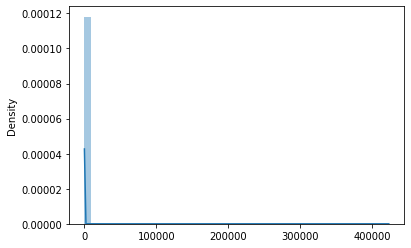

In [22]:
print('Dropped values',len(jan_df) - len(jan_df[(jan_df.duration >= 1) & (jan_df.duration <= 60)]))
sns.distplot(jan_df.duration.values)

jan_df = jan_df[(jan_df.duration >= 1) & (jan_df.duration <= 60)]

Dropped values 47579


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


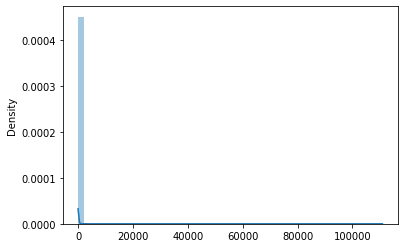

In [23]:
print('Dropped values',len(feb_df) - len(feb_df[(feb_df.duration >= 1) & (feb_df.duration <= 60)]))
sns.distplot(feb_df.duration.values)

feb_df = feb_df[(feb_df.duration >= 1) & (feb_df.duration <= 60)]

### Q3. What's the fractions of missing values for the pickup location ID?

In [26]:
jan_df['PUlocationID'].fillna(-1, inplace=True)
jan_df['DOlocationID'].fillna(-1, inplace=True)

feb_df['PUlocationID'].fillna(-1, inplace=True)
feb_df['DOlocationID'].fillna(-1, inplace=True)

print('A3:', len(jan_df.loc[jan_df['PUlocationID']==-1]) / len(jan_df))

A3: 0.8352732770722617


### Q4. What's the dimensionality of this matrix?

In [28]:
categorical = ['PUlocationID', 'DOlocationID']

jan_df[categorical] = jan_df[categorical].astype(str)
feb_df[categorical] = feb_df[categorical].astype(str)

train_dicts = jan_df[categorical].to_dict(orient='records')
dv = DictVectorizer()

X_train = dv.fit_transform(train_dicts)

print('A4:', X_train.shape[1])

A4: 525


### Q5. What's the RMSE on train?

In [29]:
target = 'duration'
y_train = jan_df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

print('A5:', mean_squared_error(y_train, y_pred, squared=False))

A5: 10.528519107210744


### Q6. What's the RMSE on validation?

In [30]:
val_dicts = feb_df[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = lr.predict(X_val)
y_val = feb_df['duration'].values

print('A6:',mean_squared_error(y_val, y_pred, squared=False))

A6: 11.364434369457998
